Load backtest object

In [1]:
import pickle

class backtest_object:
  def __init__(self,grid_search, X, y, best_estim_preds, final_model):
    self.grid_search = grid_search
    self.X = X
    self.y = y
    self.best_estim_preds = best_estim_preds
    self.final_model = best_gbm

def Acc_Score(y_true,y_pred):
    global ys
    ys.append(y_pred)
    acc = accuracy_score(y_true, y_pred)    
    return acc

# Load the object from the file
with open('backtest_object_10Y_UST_v1_1.pkl', 'rb') as file:
    backtest_object_10Y_UST_v1_1 = pickle.load(file)

In [2]:
# Print the best hyperparameters
print("Best Hyperparameters:", backtest_object_10Y_UST_v1_1.grid_search.best_params_)
print(f'Accuracy of the Best Hyperparameters: {backtest_object_10Y_UST_v1_1.grid_search.best_score_:.4f}')


Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 150, 'subsample': 0.75}
Accuracy of the Best Hyperparameters: 0.5478


In [3]:
X = backtest_object_10Y_UST_v1_1.X
y = backtest_object_10Y_UST_v1_1.y
y_preds = backtest_object_10Y_UST_v1_1.best_estim_preds

In [4]:
y.tail()

Date
2023-10-22     LONG
2023-10-29     LONG
2023-11-05    SHORT
2023-11-12     LONG
2023-11-19    SHORT
Name: YIELD_weekly_percent_change_10 YR_lead, dtype: object

In [5]:
import pandas as pd
# Merge or join with the existing merged_data
y_df = pd.DataFrame(y[(len(y) - len(y_preds)):,])
y_df['y_pred'] = y_preds

In [6]:
import sqlite3

# Create a connection to the database
conn = sqlite3.connect("Treasury_Yields_data.db" )

# Get a list of all tables in the database
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()

# Read the table into a DataFrame
query = f"SELECT Date, `10 YR` FROM YIELD_weekly_percent_change;"
T10y_df = pd.read_sql_query(query, conn, index_col='Date', parse_dates='Date')

# Read the table into a DataFrame
query = f"SELECT Date, `10 YR` FROM YIELD_weekly;"
T10y_df_lvl = pd.read_sql_query(query, conn, index_col='Date', parse_dates='Date')
T10y_df_lvl = T10y_df_lvl.rename(columns={'10 YR': '10 YR Lvl'})

In [7]:
merged_data = pd.merge(y_df, T10y_df, on='Date' ,how='left')
merged_data = pd.merge(merged_data, T10y_df_lvl, on='Date' ,how='left')

In [8]:
merged_data.tail()


,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl
Date,,,,
2023-10-22,LONG,LONG,0.064795,4.93
2023-10-29,LONG,SHORT,-0.018256,4.84
2023-11-05,SHORT,SHORT,-0.055785,4.57
2023-11-12,LONG,LONG,0.008753,4.61
2023-11-19,SHORT,LONG,-0.036876,4.44


In [9]:
merged_data['For0'] = merged_data['y_pred'].shift(periods=1)
merged_data.tail(10)

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0
Date,,,,,
2023-09-17,SHORT,LONG,0.016432,4.33,SHORT
2023-09-24,SHORT,LONG,0.025404,4.44,LONG
2023-10-01,SHORT,SHORT,0.033784,4.59,LONG
2023-10-08,LONG,LONG,0.041394,4.78,SHORT
2023-10-15,SHORT,SHORT,-0.031381,4.63,LONG
2023-10-22,LONG,LONG,0.064795,4.93,SHORT
2023-10-29,LONG,SHORT,-0.018256,4.84,LONG
2023-11-05,SHORT,SHORT,-0.055785,4.57,SHORT
2023-11-12,LONG,LONG,0.008753,4.61,SHORT


In [10]:
import numpy as np
merged_data['Pos'] = np.where(merged_data['For0'] == 'LONG' , 1, -1)
merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos
Date,,,,,,
2023-10-22,LONG,LONG,0.064795,4.93,SHORT,-1
2023-10-29,LONG,SHORT,-0.018256,4.84,LONG,1
2023-11-05,SHORT,SHORT,-0.055785,4.57,SHORT,-1
2023-11-12,LONG,LONG,0.008753,4.61,SHORT,-1
2023-11-19,SHORT,LONG,-0.036876,4.44,LONG,1


In [11]:
merged_data['Turnover'] = 1

merged_data['Turnover'] = np.where(merged_data['Pos'] == merged_data['Pos'].shift(periods=1),0,2)

merged_data['Turnover'][1] = 1


C:\Users\dstoc\AppData\Local\Temp\ipykernel_13160\3329850808.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Turnover'][1] = 1


In [12]:
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover
Date,,,,,,,
2018-09-09,SHORT,SHORT,0.027972,2.94,None,-1,2
2018-09-16,SHORT,SHORT,0.017007,2.99,SHORT,-1,1
2018-09-23,LONG,LONG,0.026756,3.07,SHORT,-1,0
2018-09-30,SHORT,SHORT,-0.006515,3.05,LONG,1,2
2018-10-07,LONG,LONG,0.059016,3.23,SHORT,-1,2


In [13]:
mat = 10
merged_data['Approx. Duration'] = (1/(merged_data['10 YR Lvl']/100)) * ( 1 - (1 / ( 1 + 0.5 * (merged_data['10 YR Lvl']/100)) ** (2 * mat)))
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration
Date,,,,,,,,
2018-09-09,SHORT,SHORT,0.027972,2.94,None,-1,2,8.609760
2018-09-16,SHORT,SHORT,0.017007,2.99,SHORT,-1,1,8.588552
2018-09-23,LONG,LONG,0.026756,3.07,SHORT,-1,0,8.554774
2018-09-30,SHORT,SHORT,-0.006515,3.05,LONG,1,2,8.563201
2018-10-07,LONG,LONG,0.059016,3.23,SHORT,-1,2,8.487787


=(2/(B3/100)^2)*(1-(1/(1+B3/200)^(20)))
-20/((B3/100)*(1+B3/200)^(21))

In [14]:
merged_data['Approx. Convexity'] = (2/((merged_data['10 YR Lvl']/100)**2)) * (1 - (1/(1+0.5*(merged_data['10 YR Lvl']/100))**(2*mat))) - (2*mat) / ((merged_data['10 YR Lvl']/100)*(1+0.5*(merged_data['10 YR Lvl']/100))**(2*mat+1))
merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity
Date,,,,,,,,,
2023-10-22,LONG,LONG,0.064795,4.93,SHORT,-1,2,7.820413,73.983613
2023-10-29,LONG,SHORT,-0.018256,4.84,LONG,1,2,7.853809,74.442897
2023-11-05,SHORT,SHORT,-0.055785,4.57,SHORT,-1,2,7.955247,75.841333
2023-11-12,LONG,LONG,0.008753,4.61,SHORT,-1,0,7.940100,75.632190
2023-11-19,SHORT,LONG,-0.036876,4.44,LONG,1,2,8.004766,76.525832


In [15]:
(1 + (merged_data['10 YR Lvl'].iloc[ 1] / 100))**(1 / 52) - 1

0.0005667318808939559

=-Dur3*(Yield3/100-Yield2/100)+0.5*Conv3*(yield3/100-yield2/100)^2+((1+yield2/100)^(1/52)-1)
duration, convexity, and carry included

https://datarepository.eur.nl/articles/dataset/Data_Treasury_Bond_Return_Data_Starting_in_1962/8152748?file=38737083

In [16]:
merged_data['ret'] = 0
# Calculate 'ret' for each row
for i in range(1, len(merged_data)):
    merged_data['ret'].iloc[i] = (-merged_data['Approx. Duration'].iloc[i] * (
            (merged_data['10 YR Lvl'].iloc[i] / 100) - (merged_data['10 YR Lvl'].iloc[i - 1] / 100)
        )) + (0.5 * merged_data['Approx. Convexity'].iloc[i] * (
            (merged_data['10 YR Lvl'].iloc[i] / 100) - (merged_data['10 YR Lvl'].iloc[i - 1] / 100)
        )**2) + (
            (1 + (merged_data['10 YR Lvl'].iloc[i - 1] / 100))**(1 / 52) - 1
        )

C:\Users\dstoc\AppData\Local\Temp\ipykernel_13160\2391953352.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['ret'].iloc[i] = (-merged_data['Approx. Duration'].iloc[i] * (


In [17]:
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret
Date,,,,,,,,,,
2018-09-09,SHORT,SHORT,0.027972,2.94,None,-1,2,8.609760,84.981580,0.000000
2018-09-16,SHORT,SHORT,0.017007,2.99,SHORT,-1,1,8.588552,84.682355,-0.003726
2018-09-23,LONG,LONG,0.026756,3.07,SHORT,-1,0,8.554774,84.206194,-0.006250
2018-09-30,SHORT,SHORT,-0.006515,3.05,LONG,1,2,8.563201,84.324935,0.002296
2018-10-07,LONG,LONG,0.059016,3.23,SHORT,-1,2,8.487787,83.263379,-0.014565


In [18]:
#-merged_data['Approx. Duration'][row]*((merged_data['10 YR Lvl'][row]/100)-(merged_data['10 YR Lvl'][row - 1]/100))+0.5*merged_data['Approx. Convexity'][row]*((merged_data['10 YR Lvl'][row]/100)-(merged_data['10 YR Lvl'][row - 1]/100))^2+((1+(merged_data['10 YR Lvl'][row - 1]/100))^(1/52)-1)

In [19]:
#merged_data = merged_data[1:] # drpo first row with no prediction
merged_data['trade ret'] = merged_data['ret'] * merged_data['Pos'] - (merged_data['Turnover'] * .0009)
merged_data['trade ret'].iloc[0] = 0
merged_data.head()

C:\Users\dstoc\AppData\Local\Temp\ipykernel_13160\3207464379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['trade ret'].iloc[0] = 0


,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret,trade ret
Date,,,,,,,,,,,
2018-09-09,SHORT,SHORT,0.027972,2.94,None,-1,2,8.609760,84.981580,0.000000,0.000000
2018-09-16,SHORT,SHORT,0.017007,2.99,SHORT,-1,1,8.588552,84.682355,-0.003726,0.002826
2018-09-23,LONG,LONG,0.026756,3.07,SHORT,-1,0,8.554774,84.206194,-0.006250,0.006250
2018-09-30,SHORT,SHORT,-0.006515,3.05,LONG,1,2,8.563201,84.324935,0.002296,0.000496
2018-10-07,LONG,LONG,0.059016,3.23,SHORT,-1,2,8.487787,83.263379,-0.014565,0.012765


In [20]:
merged_data['cumulative_ret'] = (merged_data['trade ret'] +1).cumprod()
merged_data['static_long_ret'] = (merged_data['ret'] + 1).cumprod()
merged_data['static_short_ret'] = (merged_data['ret']*-1 + 1).cumprod()
merged_data.head()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret,trade ret,cumulative_ret,static_long_ret,static_short_ret
Date,,,,,,,,,,,,,,
2018-09-09,SHORT,SHORT,0.027972,2.94,None,-1,2,8.609760,84.981580,0.000000,0.000000,1.000000,1.000000,1.000000
2018-09-16,SHORT,SHORT,0.017007,2.99,SHORT,-1,1,8.588552,84.682355,-0.003726,0.002826,1.002826,0.996274,1.003726
2018-09-23,LONG,LONG,0.026756,3.07,SHORT,-1,0,8.554774,84.206194,-0.006250,0.006250,1.009094,0.990047,1.010000
2018-09-30,SHORT,SHORT,-0.006515,3.05,LONG,1,2,8.563201,84.324935,0.002296,0.000496,1.009595,0.992320,1.007681
2018-10-07,LONG,LONG,0.059016,3.23,SHORT,-1,2,8.487787,83.263379,-0.014565,0.012765,1.022482,0.977867,1.022358


In [21]:

merged_data.tail()

,YIELD_weekly_percent_change_10 YR_lead,y_pred,10 YR,10 YR Lvl,For0,Pos,Turnover,Approx. Duration,Approx. Convexity,ret,trade ret,cumulative_ret,static_long_ret,static_short_ret
Date,,,,,,,,,,,,,,
2023-10-22,LONG,LONG,0.064795,4.93,SHORT,-1,2,7.820413,73.983613,-0.022258,0.020458,0.864234,0.961672,1.008247
2023-10-29,LONG,SHORT,-0.018256,4.84,LONG,1,2,7.853809,74.442897,0.008024,0.006224,0.869614,0.969388,1.000156
2023-11-05,SHORT,SHORT,-0.055785,4.57,SHORT,-1,2,7.955247,75.841333,0.022665,-0.024465,0.848338,0.991360,0.977488
2023-11-12,LONG,LONG,0.008753,4.61,SHORT,-1,0,7.940100,75.632190,-0.002310,0.002310,0.850298,0.989069,0.979746
2023-11-19,SHORT,LONG,-0.036876,4.44,LONG,1,2,8.004766,76.525832,0.014586,0.012786,0.861170,1.003496,0.965456


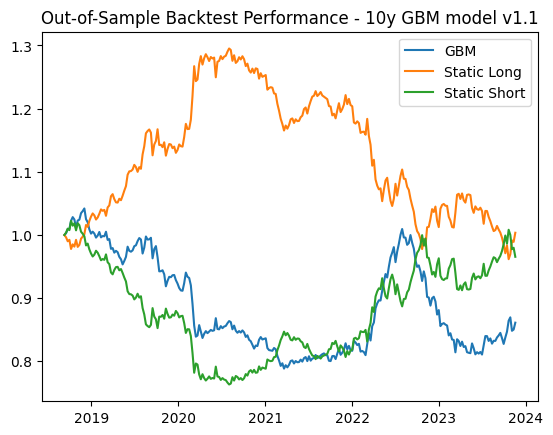

In [22]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(merged_data.index, merged_data['cumulative_ret'], label='GBM')
plt.plot(merged_data.index, merged_data['static_long_ret'], label='Static Long')
plt.plot(merged_data.index, merged_data['static_short_ret'], label='Static Short')
plt.title('Out-of-Sample Backtest Performance - 10y GBM model v1.1')
plt.legend()

In [23]:
cum_ret_gbm = merged_data['cumulative_ret'][-1]
cum_ret_static_long = merged_data['static_long_ret'][-1]
cum_ret_static_short = merged_data['static_short_ret'][-1]

print(f'Out-of-Sample Cumulative Return of GBM: {cum_ret_gbm:.4f}')
print(f'Out-of-Sample Cumulative Return of Static Long: {cum_ret_static_long:.4f}')
print(f'Out-of-Sample Cumulative Return of Static Short: {cum_ret_static_short:.4f}')
import pandas as pd
import numpy as np


returns_df = merged_data.copy()

# Calculate drawdowns
returns_df['Peak'] = returns_df['cumulative_ret'].cummax()
returns_df['Drawdown'] = (returns_df['cumulative_ret'] / returns_df['Peak']) - 1

# # Find drawdowns
# drawdowns = returns_df[returns_df['Drawdown'] < 0]

# Calculate drawdown metrics
# Initialize lists to store drawdown metrics
drawdown_lengths = []
drawdown_depths = []
drawdown_dates = []

current_length = 0
current_depth = 0
current_start_date = None

for date, drawdown in zip(returns_df.index, returns_df['Drawdown']):
    if drawdown < 0:
        current_length += 1
        current_depth = min(current_depth, drawdown)
        if current_start_date is None:
            current_start_date = date
    else:
        if current_length > 0:
            drawdown_lengths.append(current_length)
            drawdown_depths.append(current_depth)
            drawdown_dates.append(current_start_date)
            current_length = 0
            current_depth = 0
            current_start_date = None
    

if current_length > 0:
    drawdown_lengths.append(current_length)
    drawdown_depths.append(current_depth)
    drawdown_dates.append(current_start_date)

# Calculate average length of drawdowns
average_drawdown_length = np.mean(drawdown_lengths)

# Identify the date, length, and depth of the longest drawdown
longest_drawdown_index = np.argmax(drawdown_lengths)
longest_drawdown_date = drawdown_dates[longest_drawdown_index]
longest_drawdown_length = drawdown_lengths[longest_drawdown_index]
longest_drawdown_depth = drawdown_depths[longest_drawdown_index]

print("Average Drawdown Length:", average_drawdown_length, "weeks")
print("Date of the Longest Drawdown:", longest_drawdown_date)
print("Length of the Longest Drawdown:", longest_drawdown_length, "weeks")
print(f"Depth of the Longest Drawdown: {longest_drawdown_depth:.4f}")

# Calculate Sortino ratio
risk_free_rate = 0.00  # replace with the actual risk-free rate
downside_returns = returns_df['trade ret'][returns_df['trade ret'] < 0]
downside_deviation = np.std(downside_returns)

sortino_ratio = (np.mean(returns_df['trade ret']) - risk_free_rate) / downside_deviation
print(f"Sortino Ratio: {sortino_ratio:.4f}")

# Calculate Sharpe ratio
sharpe_ratio = (np.mean(returns_df['trade ret']) - risk_free_rate) / np.std(returns_df['trade ret'])
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Calculate Information Ratio
benchmark_returns = returns_df['ret'] # static long
excess_returns = returns_df['trade ret'] - benchmark_returns
information_ratio = np.mean(excess_returns) / np.std(excess_returns)
print(f"Information Ratio: {information_ratio:.4f}")

Hit_rate = returns_df['trade ret'][returns_df['trade ret'] > 0].count() / returns_df['trade ret'].count()
print(f'Hit Rate: {Hit_rate:.4f}')

subset_df = returns_df[returns_df['Pos'] == -1 ]
subset_df["short_cum_ret"] = (subset_df['trade ret'] +1).cumprod()
cum_ret_shorts = subset_df['short_cum_ret'][-1]
print(f'Cumulative Return of Shorts: {cum_ret_shorts:.4f}')
subset_df2 = returns_df[(returns_df['Pos'] == -1) & (returns_df['trade ret'] > 0)]
short_Hit_rate = subset_df2['Pos'].count() / returns_df['Pos'][returns_df['Pos'] == -1].count()
print(f'Hit Rate of Shorts: {short_Hit_rate:.4f}')


subset_df = returns_df[(returns_df['Pos'] == 1) ]
subset_df["long_cum_ret"] = (subset_df['trade ret'] +1).cumprod()
cum_ret_longs = subset_df['long_cum_ret'][-1]
print(f'Cumulative Return of Longs: {cum_ret_longs:.4f}')
subset_df2 = returns_df[(returns_df['Pos'] == 1) & (returns_df['trade ret'] > 0)]
long_Hit_rate = subset_df2['Pos'].count() / returns_df['Pos'][returns_df['Pos'] == 1].count()
print(f'Hit Rate of Longs: {long_Hit_rate:.4f}')


Out-of-Sample Cumulative Return of GBM: 0.8612
Out-of-Sample Cumulative Return of Static Long: 1.0035
Out-of-Sample Cumulative Return of Static Short: 0.9655
Average Drawdown Length: 131.5 weeks
Date of the Longest Drawdown: 2018-12-09 00:00:00
Length of the Longest Drawdown: 259 weeks
Depth of the Longest Drawdown: -0.2433
Sortino Ratio: -0.0640
Sharpe Ratio: -0.0454
Information Ratio: -0.0363
Hit Rate: 0.5110
Cumulative Return of Shorts: 0.9193
Hit Rate of Shorts: 0.5158
Cumulative Return of Longs: 0.9368
Hit Rate of Longs: 0.5085


C:\Users\dstoc\AppData\Local\Temp\ipykernel_13160\1813287942.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["short_cum_ret"] = (subset_df['trade ret'] +1).cumprod()
C:\Users\dstoc\AppData\Local\Temp\ipykernel_13160\1813287942.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["long_cum_ret"] = (subset_df['trade ret'] +1).cumprod()


In [24]:
backtest_results = returns_df.copy()

In [25]:
import pickle

# Serialize the object using pickle and save to a file
with open('backtest_results_10Y_UST_v1_1.pkl', 'wb') as file:
    pickle.dump(backtest_results, file)